In this notebook, we'll take a closer look at the Principal Component Analysis (PCA). PCA is a technique that lets us reduce the number of features in our dataset and perform faster model training and testing.

For the purpose of this demonstration, we will use the MNIST dataset. We'll also use a logistic regression model to categorize digits.

First, we'll perform the model training without PCA. Then, we'll implement the Principal Component Analysis and finally, we'll compare our version's performance with scikit's implementation.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
data = pd.read_csv('../input/digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


First, I will split the data into training and validation sets using scikit's train_test_split function. 
I use 30% of training data as my validation set.

In [3]:
labels = data['label']
features = data.drop('label', axis=1)

train, val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=42)

The data is a set of image of size 28x28 pixels. Each image is represented as a set of pixel colors unfolded into a single row, which gives us 28x28=784 features. 

Let's look at an example image from the data

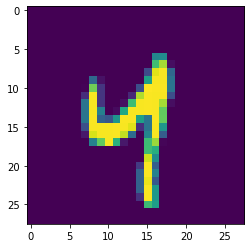

In [4]:
image_pixels = train.iloc[0].values.reshape(28,28)
plt.imshow(image_pixels)

# Performing the model training without PCA

First, we will see how logistic regression performs without Principal Component Analysis. We also won't be using standarization for now.

In [5]:
X = train.values
X_val = val.values

model = LogisticRegression()

start = time.time()
model.fit(X, y_train)
stop = time.time()

predictions = model.predict(X_val)
accuracy = accuracy_score(y_val, predictions)
print(f'Liczba składowych: {X.shape[1]}. Czas: {stop - start:.2f}s. Accuracy:{accuracy:.2f}.')

Liczba składowych: 784. Czas: 7.91s. Accuracy:0.92.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The model performed 100 iterations in 8 seconds. It's not much in case of this particular dataset, but imagine having  more features. This could take much, much longer. That is why we use PCA.

# Preprocessing the data

784 features is a bit much, so we're going to use PCA (Principal Component Analysis) to reduce the dimensionality of our data. This will be our own implementation, which we'll compare later to the scikit's version.

1. To use PCA, we have to perform standarization of the data first. To make things more interesting, instead of using scikit's StandardScaler, we'll create and use our own implementation

In [6]:
class CustomStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, mean=0, std=1):
        self.mean = mean
        self.std = std
    def fit(self, X, y=None):
        '''
        Calculates the mean and std of each column of X
        and assigns it to instance attributes.
        For this transformer, we'll only use the X attribute
        
        X - for simplicity, we'll assume it is a numpy's ndarray
        '''
        self.mean = X.mean(axis=0)
        self.std = np.std(X, axis=0)
        # if standard deviation equals 0, we want to change it to 1
        # so it doesn't break our scaler
        self.std[self.std == 0] = 1
        return self
    def transform(self, X, y=None):
        '''
        Performs the standarization of X
        using the parameters set in fit method.
        
        X - for simplicity, we'll assume it is a numpy's ndarray
        '''
        return (X - self.mean) / self.std

In [7]:
scaler = CustomStandardScaler()

X = train.values
X = scaler.fit_transform(X)

2. Next, we calculate covariance matrix, which defines how correlated the features are with each other.

In [8]:
m = X.shape[0]
covariance_matrix = 1/m * X.T.dot(X)
covariance_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

3. We perform SVD (Singular Value Decomposition) of the covariance matrix.

In [9]:
U, S, V = np.linalg.svd(covariance_matrix)

# Training the model

Now we will train the model using first k computed features. What should the value of k be? We don't know that yet, so we're going to try different values and evaluate the models on the validation set. We will choose k with the highest accuracy.

We will also check, how much variance was retained using the S matrix from cell above

Now we will use matrix S to see, how much variance do we retain depending on the value of k.

The explained variance tells us, how much variance of the data is described by each principal component.
When we sum the first k elements of the explained variance list and divide it by sum of all elements, we get a percentage of variation retained within first k elements.

In [10]:
variance_explained = []
for eigen_value in S:
    variance_explained.append((eigen_value/sum(S))*100)
        
cumulative_variance_explained = np.cumsum(variance_explained)

We can also plot this cumulative sums as a function of k values

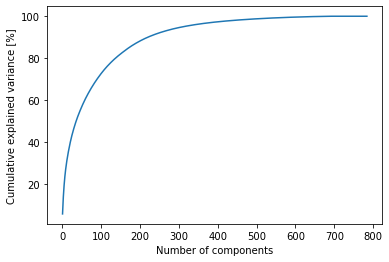

In [11]:
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance [%]")
plt.show()

As we can see, the more principal components we use, the more variance of our data we keep.

In [12]:
X_val = val.values
X_val = scaler.transform(X_val)

In [13]:
for k in range(1, 784, 150):
    U_reduced = U[:,0:k]
    
    X_train_reduced = X.dot(U_reduced)
    y_train
    X_val_reduced = X_val.dot(U_reduced)
    y_val    
    
    # training with time measurements
    model = LogisticRegression()
    start = time.time()
    model.fit(X_train_reduced, y_train)
    stop = time.time()
    
    # retained variance
    retained_variance = cumulative_variance_explained[k - 1]

    predictions = model.predict(X_val_reduced)
    accuracy = accuracy_score(y_val, predictions)
    print(f'Liczba składowych: {k}. Czas: {stop - start:.2f}s. Accuracy:{accuracy:.2f}. Zachowana wariancja: {retained_variance:.2f}%.')

Liczba składowych: 1. Czas: 1.55s. Accuracy:0.30. Zachowana wariancja: 5.85%.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Liczba składowych: 151. Czas: 2.97s. Accuracy:0.92. Zachowana wariancja: 82.16%.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Liczba składowych: 301. Czas: 4.12s. Accuracy:0.92. Zachowana wariancja: 94.63%.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Liczba składowych: 451. Czas: 5.03s. Accuracy:0.91. Zachowana wariancja: 98.18%.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Liczba składowych: 601. Czas: 6.01s. Accuracy:0.91. Zachowana wariancja: 99.60%.
Liczba składowych: 751. Czas: 7.19s. Accuracy:0.91. Zachowana wariancja: 100.00%.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We'd like to retain at least about 95%, so judging by the above results, a reasonable k to choose would be around 350.
Let's train the model with this parameter then, check the results and run it on the test set

In [14]:
best_k = 350

U_reduced = U[:,0:best_k]
    
X_train_reduced = X.dot(U_reduced)
y_train
X_val_reduced = X_val.dot(U_reduced)
y_val 

# training with the best parameters
model = LogisticRegression(max_iter=800)
start = time.time()
model.fit(X_train_reduced, y_train)
stop = time.time()

predictions = model.predict(X_val_reduced)
accuracy = accuracy_score(y_val, predictions)
print(f'Liczba składowych: {best_k}. Czas: {stop - start:.2f}s. Accuracy:{accuracy:.2f}.')

Liczba składowych: 350. Czas: 31.23s. Accuracy:0.92.


In [15]:
X_test = pd.read_csv('../input/digit-recognizer/test.csv').values
X_test = scaler.transform(X_test)

Z_test = X_test.dot(U_reduced)
X_test_reduced = Z_test
    
test_predictions = model.predict(X_test_reduced)

# Using the sklearn's PCA

Now, we will compare the results of our model with the scikit's implementation. We'll use the best_k value as the number of components

In [16]:
scaler = StandardScaler()

X = train.values
X = scaler.fit_transform(X)

X_val = val.values
X_val = scaler.transform(X_val)

In [17]:
pca = PCA(n_components=best_k)
X_train_reduced = pca.fit_transform(X)
X_val_reduced = pca.transform(X_val)

In [18]:
# training with time measurements
model = LogisticRegression(max_iter=800)
start = time.time()
model.fit(X_train_reduced, y_train)
stop = time.time()

predictions = model.predict(X_val_reduced)
accuracy = accuracy_score(y_val, predictions)
print(f'Liczba składowych: {best_k}. Czas: {stop - start:.2f}s. Accuracy:{accuracy:.2f}.')

Liczba składowych: 350. Czas: 29.84s. Accuracy:0.92.


Although times may differ a bit due to system's resource allocation, we can see that the scikit's PCA gives us the same results as our implementation.

Lastly, we can upload the results to the leaderboards, because why not...

In [19]:
image_id = range(1, len(test_predictions) + 1)
my_submission = pd.DataFrame({'ImageId': image_id, 'Label': test_predictions})

my_submission.to_csv('submission.csv', index=False)

# Bibliography

- [Andrew Ng's Machine Learning Course](https://www.coursera.org/learn/machine-learning)
- [scikit's PCA documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [PCA explanation](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c)

I also used materials from lectures at my university.